# K-Nearest Neighbors Model for Admission to UC
Barak Krakauer, June 2016   (Updated September, 2016)

## About this project:

In this project, I create a model that predicts, given a student's GPA and the income of his or her city, whether he or she will be admitted into University of California system. The model is based on data provided by the University of California and by the US Census Bureau. 

This project makes use of five files:
+ UC Admissions by High School for 2015, which states, for every California HS, the number of students (broken down by ethnicity) who applied, were accepted to, and enrolled in UC for 2015.
+ UC Admissions GPAs for 2015, which states, for every California HS, the mean GPA of students who applied, were accepted to, and enrolled in UC for 2015.
+ Median Income by Zip Code, 2014.
+ Zip Code of California High Schools (generated with the help of the Google Maps API)

It should be noted that student level data is simulated, since the data is only available at a high school level. Each student is assigned a randomized GPA, with in a normal distribution centered around the student's school's median GPA for applicants. A student is admitted, based on this model, if they have one of the top n GPAs fromthe school, where n is the number of students accepted from the school. Such a model is simplified, compared to the actual admissions process, but generates results that are largely in line with the demographics and GPA of the actual incoming class.

This project also involves the larger question of what factors determine whether a student is accepted into a UC. While I did not have access to all of the factors I would have liked, I did have access to data about the ethnicities of students who apply and are accepted into the UC system. Ultimately I determined that, taken alone, a student's ethnicity does correlate with admissions; however, factors such as GPA and (to a lesser extent) citywide income seem to screen off this influence and ultimately outweigh the relevance of ethnicity. This version of the project does not attempt to model the (very small) effects of ethnicity.



In [1]:
# Imports and display settings

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model, neighbors, ensemble, cross_validation, grid_search, metrics
import helper as h

%matplotlib inline
plt.style.use('ggplot')

## Importing and Cleaning Data

Below, I'll use my helper function to import and do some basic cleaning on our dataframes. I'll be using:
+ UC Admissions data from 2015, which contains, for each high school, the number of applicants, admitted students, and mean GPA of applicants and admitted students.
+ The median income of each Zip Code in CA
+ The Zip Code of each HS in CA

In [2]:
df = pd.read_csv("gpas_w_zips.csv")
df.fillna(0)
df[["App GPA", "Adm GPA"]] = df[["App GPA", "Adm GPA"]].astype(float)
df["Zip"] = df["Zip"].astype(int)
df["Income"] = df["Income"].astype(int)
df["Admitted"] = df["Admitted"].astype(int)
df["Applied"] = df["Applied"].astype(int)
df.drop("Unnamed: 0", axis=1, inplace=True)

In [3]:
df.head()

,School Name,City,County,Admitted,Applied,App GPA,Adm GPA,Enrl GPA,Zip,Income
0,A B MILLER HIGH SCHOOL,Fontana,San Bernardino,42,76,3.44,3.71,3.84,92336,81608
1,ABRAHAM LINCOLN HIGH SCHOOL,Los Angeles,Los Angeles,49,82,3.52,3.80,3.87,90031,34035
2,ABRAHAM LINCOLN HIGH SCHOOL,San Francisco,San Francisco,100,184,3.54,3.80,3.81,94116,95090
3,ABRAHAM LINCOLN HIGH SCHOOL,San Jose,Santa Clara,45,78,3.82,4.01,4.11,95126,71585
4,ACAD FOR ACADEMIC EXCELLENCE,Apple Valley,San Bernardino,8,23,3.63,4.16,NaN,92307,57654


## Generate simulated student-level data from the high school-level data

This will execute code in the helper function which will generate simulated student-level data. The idea is to pass the function high school level data, and then generate, for each applicant:
+ An ethnicity, assigned according to the ethnicities of the applicants from that high school.
+ An income, matched to that city's median income
+ An admissions decision, determined by whether that student has one of the n highest GPAs in that high school (where n = the number of students admitted).

Note that a previous version of this project also simulated student ethnicity.

In [4]:
students = pd.DataFrame({})

for i in range(len(df)):
    students = students.append(h.simulate_hs(df.iloc[i,:]))

In [5]:
students.head()

,Admitted,City,County,Income,School,Student GPA
0,0,Fontana,San Bernardino,81608,A B MILLER HIGH SCHOOL,3.15
1,1,Fontana,San Bernardino,81608,A B MILLER HIGH SCHOOL,3.58
2,1,Fontana,San Bernardino,81608,A B MILLER HIGH SCHOOL,3.49
3,1,Fontana,San Bernardino,81608,A B MILLER HIGH SCHOOL,3.47
4,1,Fontana,San Bernardino,81608,A B MILLER HIGH SCHOOL,3.61


## Data Exploration & Visualization

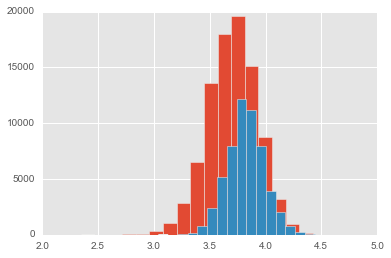

In [6]:
students["Student GPA"].hist(bins = 20)
students[students.Admitted == 1]["Student GPA"].hist(bins = 20)

Note how the student GPAs and admitted student GPAs both fall in a normal distribution with a similar shape, with the admitted GPAs shifted to the right.

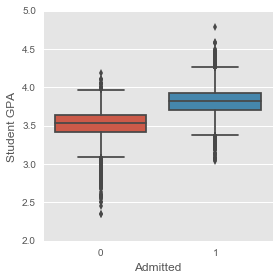

In [7]:
sns.factorplot(x = 'Admitted',
    y = 'Student GPA',
    data = students,
    kind = 'box')

Another illustration of the shape of the applicant and admitted GPAs.

How close is our estimated student-level data to the actual data with respect to academic performance?

In [8]:
print "Average admitted student gpa (simulated):", np.mean(students[students.Admitted == 1]["Student GPA"])
print "Average admitted student gpa (actual): ", np.mean(df['Adm GPA'])

Average admitted student gpa (simulated): 3.81903903576
Average admitted student gpa (actual):  3.91905052265


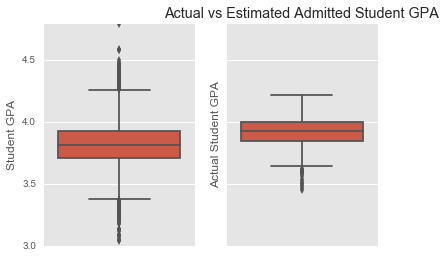

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.boxplot(y="Student GPA", data = students[students.Admitted == 1], ax=ax1)
sns.axlabel(" ", "Estimated Student GPA")
sns.boxplot(y="Adm GPA", data = df, ax=ax2)
sns.axlabel(" ", "Actual Student GPA")
sns.plt.title("Actual vs Estimated Admitted Student GPA")

Future versions of this model will atempt to further refine the GPA code to make the simluated student data better match the aggregate data that is available. It should be noted, however, that the GPA data matches quite closely; the larger variance of the simulated data is to be expected, given that this GPA data is generated per student, rather than per high school.

## Income, GPA, and Admissions:

In [10]:
students[['Admitted', 'Student GPA', 'Income']].corr()

,Admitted,Student GPA,Income
Admitted,1.000000,0.655042,0.086701
Student GPA,0.655042,1.000000,0.305561
Income,0.086701,0.305561,1.000000


(0.0, 250000.0)

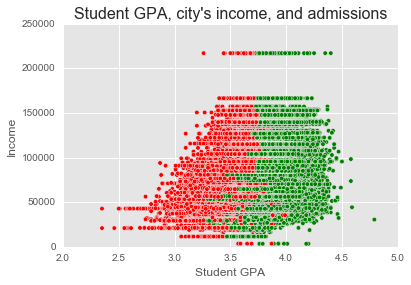

In [11]:
color = students.Admitted.map({0: 'red', 1: 'green'})
axes = students.plot('Student GPA', 'Income', kind = 'scatter', c = color)
axes.set_title("Student GPA, city's income, and admissions", fontsize = 16)

axes.set_xlim(2.0)

axes.set_ylim(.0)

The outliers toward the top of this graph represent Menlo Atherton High School in Atherton. 175 students applied from there, and 121 were admitted. The median income of this zip code is 216905.

It is obvious, looking at the X-axis, that higher GPAs result in greater admissions. Looking at the Y-axis, one can also see that admissions are slightly top-heavy, so the effect there is evident as well. It should also be noted that there is a great deal of "locality", in the sense that admits and non-admits cluster together. This suggests that KNN might be an effective model.

In [12]:
df["Percent"] = df.Admitted * 1.0 / df.Applied

(0, 200000)

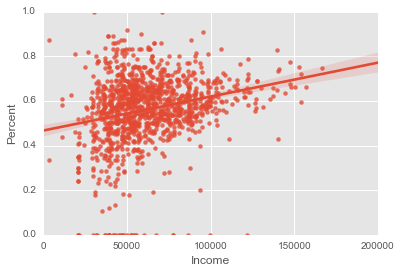

In [13]:
a = sns.regplot(x="Income", y="Percent", data=df)
a.set_ylim(0,1)
a.set_xlim(0,200000)

(0, 1)

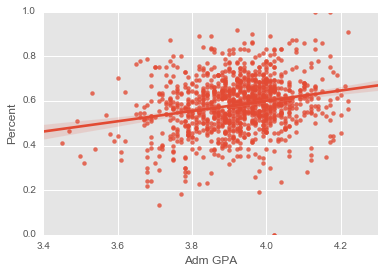

In [14]:
a = sns.regplot(x="Adm GPA", y="Percent", data=df)
a.set_ylim(0,1)

These graphs (looking at the actual, per high school data) show that the percentage of students who are admitted from a high school are positively correlated with the school's median income and the GPA of its students though R^2 is rather high.

## Building Models

We will add a colum here to represent normalized income. This is because median income is a 5- or 6-digit integer, while the other scalar value, GPA, is on a scale of (roughly) 0-5. This will help the logistic regression, below.

In [15]:
# Add a column of normalized student income to match the scale of GPA
maxval = max(students.Income) * 1.0
minval = min(students.Income) * 1.0
students["Income_N"] = students.Income.apply(lambda x: ((x - minval) / (maxval - minval)))

In [16]:
students.head()

,Admitted,City,County,Income,School,Student GPA,Income_N
0,0,Fontana,San Bernardino,81608,A B MILLER HIGH SCHOOL,3.15,0.366415
1,1,Fontana,San Bernardino,81608,A B MILLER HIGH SCHOOL,3.58,0.366415
2,1,Fontana,San Bernardino,81608,A B MILLER HIGH SCHOOL,3.49,0.366415
3,1,Fontana,San Bernardino,81608,A B MILLER HIGH SCHOOL,3.47,0.366415
4,1,Fontana,San Bernardino,81608,A B MILLER HIGH SCHOOL,3.61,0.366415


In [17]:
students.reset_index(drop=True, inplace=True)

In [18]:
# Separate the data into training and testing sets.
print len(students)
train_df = students.sample(frac = .6)
print len(train_df)
test_df = students.drop(train_df.index)
print len(test_df)

90333
54200
36133


In [19]:
# Setting the features of our model

train_X = train_df[['Student GPA', 'Income']]
train_y = train_df.Admitted
test_X = test_df[['Student GPA', 'Income']]
test_y = test_df.Admitted

#These are normalized versions of the training and testing data (where income is scaled)

train_X_n = train_df[['Student GPA', 'Income_N']]
test_X_n = test_df[['Student GPA', 'Income_N']]

## Model 1: Logistic Regression

In [20]:
logmodel = linear_model.LogisticRegression()
logmodel.fit(train_X_n, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
# Score the model based on training data.
logmodel.score(train_X_n, train_y)

0.83282287822878232

In [22]:
# Score the model based on testing data.
logmodel.score(test_X_n, test_y)

0.83250767996014718

In [23]:
logmodel2 = linear_model.LogisticRegression()
logmodel.fit(train_X, train_y)
logmodel.score(train_X, train_y)

0.60942804428044284

## Model 2: K Nearest Neighbors

In [24]:
knnmodel = neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
knnmodel.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

In [25]:
cross_validation.cross_val_score(knnmodel, train_X, train_y, cv = 5).mean()


0.94833949513534377

In [26]:
knnmodel.score(test_X, test_y)

0.94755486674231315

## Model 3: Random Forest

In [27]:
rfmodel = ensemble.RandomForestClassifier(n_estimators = 1000, oob_score = True)

rfmodel.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [28]:
rfmodel.oob_score_

0.91998154981549818

In [29]:
cross_validation.cross_val_score(rfmodel, train_X, train_y, cv = 5).mean()

0.91153149097022335

In [30]:
rfmodel.score(test_X, test_y)

0.91755458998699246

The KNN and Random Forest models seem most promising. I'm going to focus on developing the KNN model, however, since a) it has the highest scores given the training data and b) the algorithm is relatively intuitive and straightforward.

## A closer look at the model's features

In [31]:
sorted(zip(rfmodel.feature_importances_, train_X.columns.values), reverse = True)

[(0.56928259843273554, 'Student GPA'), (0.4307174015672649, 'Income')]

In [32]:
print "KNN score with income alone:"
knnmodeli = neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
knnmodeli.fit(train_X[["Income"]], train_y)
print cross_validation.cross_val_score(knnmodeli, train_X["Income"].reshape(-1, 1), train_y, cv = 5).mean()

print "KNN score with GPA alone:"
knnmodelg = neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
knnmodelg.fit(train_X[["Student GPA"]], train_y)
print cross_validation.cross_val_score(knnmodelg, train_X["Student GPA"].reshape(-1,1), train_y, cv = 5).mean()

KNN score with income alone:
0.568468645118
KNN score with GPA alone:
0.796309678178


## Tuning the Model

Now, we'll use gridsearch to find the best hyperparameters for KNN. The most important parameters in the model are the number of neighbors to sample and how to weight the neighbors. The cell below will try all permutations of weights and neighbors (for k up to 20) to determine the best model, given the training data.

In [33]:
# Find the best value for k and whether weights should be uniform or distance

k_nn = range(1, 20)

gs = grid_search.GridSearchCV(
    estimator = neighbors.KNeighborsClassifier(),
    param_grid = {'n_neighbors': k_nn, 'weights' : ['distance', 'uniform']},
    cv = cross_validation.KFold(len(train_df), n_folds = 10)
)

gs.fit(train_X, train_y)  # Note that train_Xmin includes on GPA and income from the training DF.

score_df = pd.DataFrame({'k': [score.parameters['n_neighbors'] for score in gs.grid_scores_],
    'Weights': [score.parameters['weights'] for score in gs.grid_scores_],
    'Score': [score.mean_validation_score for score in gs.grid_scores_]})

In [34]:
score_df.sort_values("Score", ascending=False)

,Score,Weights,k
8,0.950074,distance,5
14,0.950018,distance,8
4,0.950018,distance,3
10,0.949797,distance,6
16,0.949742,distance,9
12,0.949742,distance,7
6,0.949723,distance,4
20,0.949649,distance,11
18,0.949557,distance,10
22,0.949465,distance,12


In the current version of this notebook, the model with 5 neighbors and distance weighting does the best. Other runs, however, may result in different results, so for full generality, the final version of the model will simply use the highest score from this ranking.

In [35]:
optimal_k = score_df[score_df.Score == max(score_df.Score)].iloc[0, 2]
print optimal_k

5


## Applying the final model to the test data!

In [36]:
knnmodel = neighbors.KNeighborsClassifier(n_neighbors = optimal_k, weights = 'distance')
knnmodel.fit(train_X, train_y)
cross_validation.cross_val_score(knnmodel, train_X, train_y, cv = 5).mean()


0.94833949513534377

How does our model do on the testing data?

In [37]:
test_Xmin = test_df[["Student GPA", "Income"]]

knnmodel.score(test_X, test_y)

0.94755486674231315

These scores are promising. We'll evaluate the model more carefully now by looking into some more advanced metrics. First, we'll look at the confusion matrix when applied to the testing data:

In [38]:
test_df["y_hat"] = knnmodel.predict(test_X) 

In [39]:
print "KNN Model on Testing Data Set:"
tp = len(test_df[(test_df.Admitted == 1) & (test_df.y_hat == 1)])
fp = len(test_df[(test_df.Admitted == 0) & (test_df.y_hat == 1)])
tn = len(test_df[(test_df.Admitted == 0) & (test_df.y_hat == 0)])
fn = len(test_df[(test_df.Admitted == 1) & (test_df.y_hat == 0)])

print "True positives:", tp, "Rate (Sensitivity):", float(tp) / len(test_df[test_df.Admitted == 1])
print "False positives:", fp, "Rate (Fall-out):", float(fp) / len(test_df[test_df.Admitted == 0])
print "True negatives:", tn, "Rate:", float(tn) / len(test_df[test_df.Admitted == 0])
print "False negatives:", fn, "Rate:", float(fn) / len(test_df[test_df.Admitted == 1])

KNN Model on Testing Data Set:
True positives: 20890 Rate (Sensitivity): 0.954186269584
False positives: 892 Rate (Fall-out): 0.0626404494382
True negatives: 13348 Rate: 0.937359550562
False negatives: 1003 Rate: 0.0458137304161


We can also visualize the models' performance by looking at the ROC (Receiver Operating Curve), which plots the true positive rate against the false-positive rate -- this plot is represented in red. As the model correctly predicts admissions, the red line moves toward y=1; false positives pull the line toward x=1. They grey dashed line represents the model guessing at chance. The AUC (Area Under Curve) measures the portion of the graph beneath the red region.

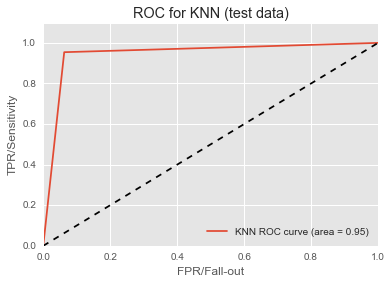

In [40]:
fpr, tpr, thresholds = metrics.roc_curve(test_df.Admitted, test_df.y_hat)

plt.figure()
plt.plot(fpr, tpr, label = 'KNN ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([.0, 1.])
plt.ylim([.0, 1.1])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("ROC for KNN (test data)")
plt.legend(loc = 'lower right')
plt.show()